# 1. Import Libraries

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pearsonr, kendalltau
from scipy import stats
from scipy.stats import randint, uniform
from wordcloud import WordCloud
from collections import Counter
import re
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
import string
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nlp_id.lemmatizer import Lemmatizer
from indoNLP.preprocessing import replace_slang, replace_word_elongation
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
import tensorflow as tf
import tensorflow_hub as tf_hub
import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')

# 2. Data Loading

In [3]:
# Download dataset
dataset = kagglehub.dataset_download("ucupsedaya/gojek-app-reviews-bahasa-indonesia")
path = r"C:\Users\User\.cache\kagglehub\datasets\ucupsedaya\gojek-app-reviews-bahasa-indonesia\versions\2\GojekAppReviewV4.0.0-V4.9.3_Cleaned.csv"
print("Path to dataset files:", dataset)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\ucupsedaya\gojek-app-reviews-bahasa-indonesia\versions\2


## 2.1 Dataset Preview

In [4]:
data = pd.read_csv(path)
data.head(5)

,userName,content,score,at,appVersion
0,Yuga Edit,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3
1,ff burik,Lambat sekali sekarang ini bosssku apk gojek g...,3,2021-11-30 15:40:38,4.9.3
2,Anisa Suci Rahmayuliani,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3
3,naoki yakuza,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3
4,Trio Sugianto,Mantap,5,2022-01-15 10:05:27,4.9.3


## 2.2 Dataset Details

Source : (https://www.kaggle.com/datasets/ucupsedaya/gojek-app-reviews-bahasa-indonesia/data) <br>

| No | columns | data type | details|
|----|----|-----|-----|
| 1 | userName | object| Nama pengguna aplikasi|
| 2 | content | object | Komentar atau feedback yang diberikan oleh pengguna|
| 3 | score | int | Skor yang diberikan oleh pengguna dalam bentuk rating 1 - 5|
| 4 | at | object | Tanggal dan waktu ketika feedback atau komentar diberikan|
| 5 | appVesion | object | Versi aplikasi yang digunakan pengguna|

# 3. Exploratory Data Analysis (EDA)

In [5]:
# Cek info data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225002 entries, 0 to 225001
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userName    225002 non-null  object
 1   content     225000 non-null  object
 2   score       225002 non-null  int64 
 3   at          225002 non-null  object
 4   appVersion  225002 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.6+ MB


- Terdapat 225.002 jumlah data
- Terdapat 4 kolom dengan tipe data object, dan 1 kolom dengan tipe data int
- Terdapat 2 missing value pada kolom content

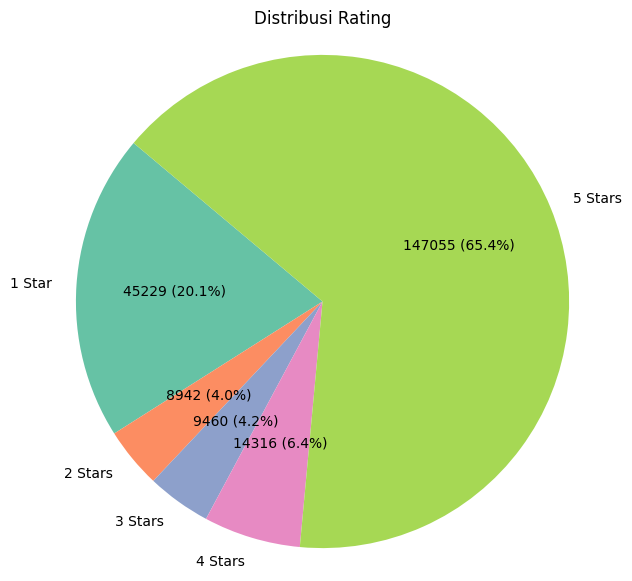

In [6]:
# Menghitung frekuensi masing-masing rating
rating_counts = data['score'].value_counts().sort_index()

# Label untuk setiap rating
rating_labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

# Membuat fungsi untuk menampilkan jumlah dan persentase
def autopct_func(pct, allvalues):
    absolute = round(pct / 100.*sum(allvalues), 0)
    return f"{int(absolute)} ({pct:.1f}%)"

# Membuat pie chart
plt.figure(figsize=(7, 7))
plt.pie(rating_counts, labels=rating_labels, autopct=lambda pct: autopct_func(pct, rating_counts), startangle=140, colors=sns.color_palette("Set2", 5))
plt.title('Distribusi Rating')
plt.axis('equal')
plt.show()

Berdasarkan diagram pie yang ditampilkan, distribusi rating dapat disimpulkan sebagai berikut:

- Sebagian besar komentar memiliki rating 5 bintang dengan persentase sebesar 65.4%, yang menunjukkan bahwa mayoritas pengguna memberikan komentar yang positive
- Rating 1 bintang menempati urutan kedua dengan persentase 20.1%, menunjukkan ada sekelompok pengguna yang tidak puas dengan aplikasi Gojek
- Rating 4 bintang memiliki persentase 6.4%, diikuti oleh rating 3 sebesar 4.2%
- Rating 2 bintang adalah yang paling sedikit diberikan, dengan persentase 4.0%

Secara keseluruhan, distribusi rating menunjukkan kecenderungan yang positive, tetapi terdapat porsi yang cukup besar juga untuk komentar negative yang dapat dilihat dari jumlah persentase rating 1.

## 3.1 Target Distribution

In [7]:
# Copy data
data2 = data.copy()

# Menambahkan kolom 'label' berdasarkan nilai score
data2['label'] = data['score'].apply(lambda x: 'negative' if x in [1, 2] else ('positive' if x in [4, 5] else None))

# Menghapus baris dengan score = 3
data2 = data2[data2['score'] != 3]

# Menampilkan hasil
data2

,userName,content,score,at,appVersion,label
0,Yuga Edit,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative
2,Anisa Suci Rahmayuliani,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive
3,naoki yakuza,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative
4,Trio Sugianto,Mantap,5,2022-01-15 10:05:27,4.9.3,positive
5,Arlan Ramlan,Bagus,4,2022-02-01 05:50:40,4.9.3,positive
...,...,...,...,...,...,...
224997,Sad Gamer,Gofood Biaya lain2ya gak ngotak mending hujan2...,1,2023-02-15 09:37:58,4.0.0,negative
224998,fadhil fadil,Yok lah,5,2021-12-11 12:28:20,4.0.0,positive
224999,g sugiarto,Sempurna,5,2022-03-14 01:45:39,4.0.0,positive
225000,J i H A D 'B E,GOJEK LAMA LAMA GAK JELAS LAGI PESEN MASA MAP...,1,2021-12-24 08:48:51,4.0.0,negative


Menambahkan kolom 'label' yang terdiri dari positive dan negative. Untuk label positive, diambil dari kolom score yang memiliki nilai 4 dan 5, sedangkan untuk label negative terdiri dari nilai 1 dan 2. Data yang memiliki nilai 3 dihilangkan karena dianggap ambigu untuk mewakili label positive atau negative (netral). Ada 9460 data yang memiliki score dengan nilai 3 atau 4,2% dari keseluruhan.

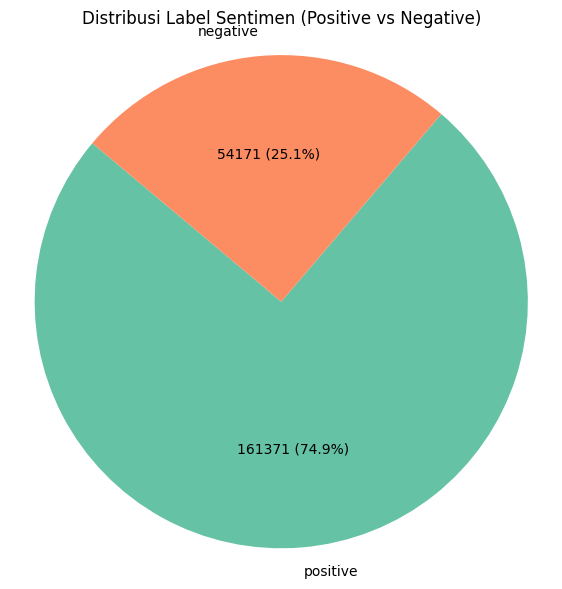

In [8]:
# Hitung distribusi label (positive vs negative)
label_counts = data2['label'].value_counts()

# Menampilkan jumlah dan persentase
def autopct_func(pct, allvals):
    absolute = round(pct / 100. * sum(allvals), 0)
    return f"{int(absolute)} ({pct:.1f}%)"

# Membuat pie chart untuk distribusi positive dan negative
plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda pct: autopct_func(pct, label_counts), startangle=140, colors=sns.color_palette("Set2", 2))
plt.title('Distribusi Label Sentimen (Positive vs Negative)')
plt.axis('equal')  # Untuk memastikan pie chart berbentuk lingkaran
plt.show()

Dari pie chart tersebut, terlihat bahwa terdapat imbalance data. Jumlah data yang memiliki label positive jauh lebih banyak dibandingkan label negative. Akan dilakukan penanganan lebih lanjut untuk data yang imbalance ini

## 3.2 Hubungan antara appVersion and Target

In [9]:
# Memastikan kolom 'appVersion' adalah string sebelum melakukan operasi
data2['appVersion'] = data2['appVersion'].astype(str)

# Memisahkan angka sebelum dan setelah titik dan mengambil hanya satu angka pertama setelah titik
data2['shortenedVersion'] = data2['appVersion'].str.extract(r'(\d+\.\d{1})')

# Menghapus kolom 'appVersion' yang lama
data3 = data2.drop(columns=['appVersion'])

# Menampilkan hasil
data3

,userName,content,score,at,label,shortenedVersion
0,Yuga Edit,akun gopay saya di blok,1,2022-01-21 10:52:12,negative,4.9
2,Anisa Suci Rahmayuliani,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,positive,4.9
3,naoki yakuza,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,negative,4.9
4,Trio Sugianto,Mantap,5,2022-01-15 10:05:27,positive,4.9
5,Arlan Ramlan,Bagus,4,2022-02-01 05:50:40,positive,4.9
...,...,...,...,...,...,...
224997,Sad Gamer,Gofood Biaya lain2ya gak ngotak mending hujan2...,1,2023-02-15 09:37:58,negative,4.0
224998,fadhil fadil,Yok lah,5,2021-12-11 12:28:20,positive,4.0
224999,g sugiarto,Sempurna,5,2022-03-14 01:45:39,positive,4.0
225000,J i H A D 'B E,GOJEK LAMA LAMA GAK JELAS LAGI PESEN MASA MAP...,1,2021-12-24 08:48:51,negative,4.0


In [10]:
#Contingency Table
contingency_table = pd.crosstab(data3['shortenedVersion'],data3['label'])
contingency_table

label,negative,positive
shortenedVersion,,
4.0,9,28
4.1,808,2781
4.2,1899,8181
4.3,12874,48403
4.4,10193,36805
4.5,9539,26048
4.6,7654,17351
4.7,8432,16696
4.8,2717,5000


- Hanya mengambil 2 angka dari appVersion, seperti vesi 4.1.5 menjadi 4.1 untuk mengurangi cardinality dan disimpan ke dalam kolom 'shortenedVersion'
- Sentimen positive mendominasi di semua versi aplikasi Gojek, Jumlah positif jauh lebih tinggi dibandingkan jumlah sentimen negatif. Persentase positif meningkat seiring kenaikan label hingga puncak di sekitar label 4.3, kemudian selalu mengalami penurunan.

In [10]:
# Hitung uji chi-square
chi2, p_value, degrees_of_freedom, expected = stats.chi2_contingency(contingency_table)  # Mengubah df2 menjadi degrees_of_freedom

# Hitung Koefisien Kontingensi
contingency_coef = np.sqrt(chi2 / (chi2 + contingency_table.sum().sum()))

print("Hasil Uji Chi-Square:")
print(f"Chi-Square: {chi2:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")

# Menginterpretasikan hasil uji
alpha = 0.05
if p_value < alpha:
    print("\nHasil: Ada hubungan signifikan antara shortenedVersion dan label (tolak H0).")
else:
    print("\nHasil: Tidak ada hubungan signifikan antara shortenedVersion dan label (gagal menolak H0).")

print("\nHasil Koefisien Kontingensi:")
print(f"Contingency Coefficient: {contingency_coef:.4f}")

Hasil Uji Chi-Square:
Chi-Square: 2900.17
P-Value: 0.0000
Degrees of Freedom: 9

Hasil: Ada hubungan signifikan antara shortenedVersion dan label (tolak H0).

Hasil Koefisien Kontingensi:
Contingency Coefficient: 0.1152


- Digunakan uji chi-squre untuk menghitung korelasi antara 2 kolom kategori
- Meskipun hasil uji chi-square menunjukkan hubungan yang signifikan, tetapi hubungan ini tergolong lemah. Dengan kata lain, hubungan antara shortenedVersion dan label ada, tetapi dampaknya kecil.

## 3.3 Wordcloud

In [11]:
# Menghapus missing value pada kolom content sebelum convert ke tipe string
data3 = data3.dropna()

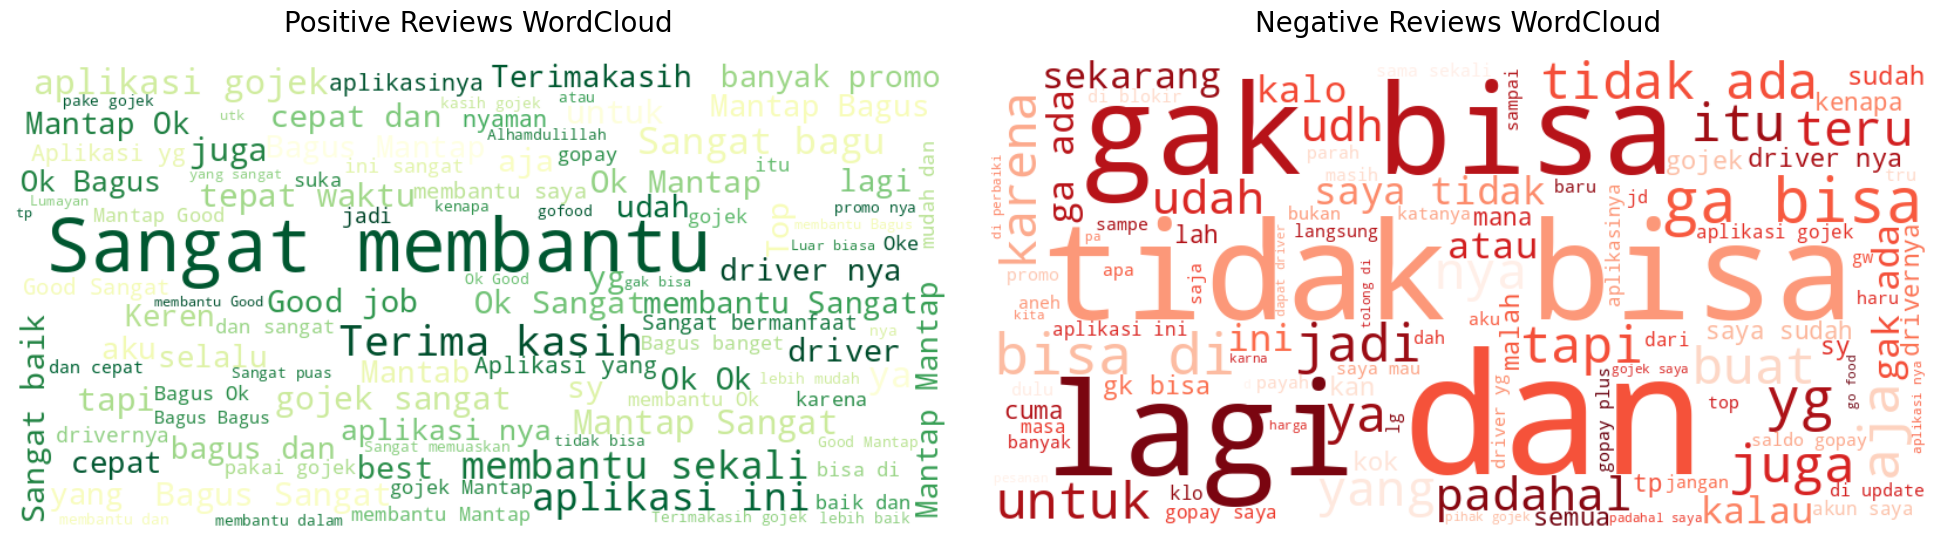


Top 10 words in Positive Reviews:
---------------------------------
membantu: 16232
Sangat: 14046
dan: 13502
Mantap: 11789
gojek: 11267
Ok: 10662
Bagus: 9302
sangat: 8653
Good: 8546
nya: 8095

Top 10 words in Negative Reviews:
---------------------------------
di: 20692
saya: 16989
bisa: 14276
nya: 11535
ada: 10870
driver: 10738
gojek: 10571
tidak: 10073
ga: 9005
yg: 8674


In [12]:
# Konversi kolom content ke string
data3['content'] = data3['content'].astype(str)

# Memisahkan teks berdasarkan label
positive_text = ' '.join(data3[data3['label'] == 'positive']['content'])
negative_text = ' '.join(data3[data3['label'] == 'negative']['content'])

# Membuat figure dengan 2 subplot
plt.figure(figsize=(20,10))

# WordCloud untuk sentimen positif
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=100,
                             colormap='YlGn').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews WordCloud', fontsize=20, pad=20)
plt.axis('off')

# WordCloud untuk sentimen negatif
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=100,
                             colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews WordCloud', fontsize=20, pad=20)
plt.axis('off')

plt.tight_layout(pad=3.0)
plt.show()

# Tampilkan kata-kata yang paling sering muncul untuk setiap sentimen
def get_top_words(text, n=10):
    # Pisahkan teks menjadi kata-kata
    words = text.split()
    # Hitung frekuensi kata
    word_freq = Counter(words)
    return word_freq.most_common(n)

print("\nTop 10 words in Positive Reviews:")
print("---------------------------------")
for word, freq in get_top_words(positive_text):
    print(f"{word}: {freq}")

print("\nTop 10 words in Negative Reviews:")
print("---------------------------------")
for word, freq in get_top_words(negative_text):
    print(f"{word}: {freq}")

- Kata yang paling sering muncul adalah "membantu", menunjukkan bahwa banyak pengguna merasa aplikasi ini sangat berguna dalam kehidupan mereka.
- Kata-kata seperti "Sangat", "Mantap", "Bagus", dan "Ok" menunjukkan penilaian positif dan kepuasan pengguna.
- Penggunaan kata "driver" dan "cepat" menunjukkan aspek layanan yang sering dipuji.
- Kata "driver" juga sering disebut dalam konteks ulasan negatif, menunjukkan bahwa masalah terkait pengemudi cukup signifikan bagi beberapa pengguna.
- Secara keseluruhan, meskipun aplikasi ini mendapatkan banyak ulasan positif dan dianggap sangat membantu oleh banyak pengguna, ada juga keluhan signifikan yang terkait dengan fungsionalitas aplikasi dan pengalaman pengguna dengan pengemudi.

# 4. Feature Engineering

In [12]:
# Mengecek data duplikat
data3.duplicated().sum()

0

Tidak terdapat data duplikat

In [13]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215540 entries, 0 to 225001
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userName          215540 non-null  object
 1   content           215540 non-null  object
 2   score             215540 non-null  int64 
 3   at                215540 non-null  object
 4   label             215540 non-null  object
 5   shortenedVersion  215540 non-null  object
dtypes: int64(1), object(5)
memory usage: 11.5+ MB


Sudah tidak terdapat missing value pada dataset, dimana sebelumnya terdapat 2 nilai NaN pada kolom 'content'

In [14]:
# Drop kolom yang tidak digunakan
df = data3.drop(columns=['userName', 'at', 'score', 'shortenedVersion'])
df.head(5)

,content,label
0,akun gopay saya di blok,negative
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,positive
3,Baru download gojek dan hape baru trus ditop u...,negative
4,Mantap,positive
5,Bagus,positive


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215540 entries, 0 to 225001
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  215540 non-null  object
 1   label    215540 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


## 4.1 Text Preprocessing

In [16]:
# Menambahkan list stopwords
additional_stopwords = [
    'nya', 'lah', 'pun', 'kah', 'tah', 'ku', 'mu', 'ya',  # Kata ganti kepunyaan
    'yang', 'dan', 'di', 'ke', 'dari', 'pada', 'dalam', 'untuk', 'dengan', # Kata penghubung
    'ini', 'itu', 'juga', 'sudah', 'saya', 'anda', 'dia', 'mereka', # Kata ganti & penunjuk
    'ada', 'akan', 'bisa', 'bila', 'seperti', 'jika', 'jika', 'namun', # Kata bantu
    'saat', 'ketika', 'karena', 'kepada', 'sebagai', 'sambil', 'dalam', # Kata keterangan
    'yakni', 'dimana', 'kemana', 'siapa', 'mengapa', # Kata tanya
    'hal', 'oleh', 'setelah', 'tentang', 'melalui', # Kata depan
    'menurut', 'hampir', 'dimana', 'bagaimana', # Kata keterangan
    'sebuah', 'seorang', 'telah', 'dapat', 'setiap', 'untuk', # Kata bantu
    'para', 'serta', 'sementara', 'tetapi', 'tapi', 'bagi', # Kata penghubung
    'sehingga', 'kendati', 'dimulai', 'kepada', # Kata penghubung
    'iyah', 'loh', 'dong', 'kok', 'sih', # Partikel percakapan
    'gue', 'gua', 'elu', 'lu', 'kamu', # Kata ganti informal
    'yah', 'deh', 'saat', 'oleh', 'tentang', # Tambahan
    'tuh', 'kan', 'tau', 'udah', 'udh', 'dah', # Kata informal
    'gitu', 'gini', 'bakal', 'bakalan', # Kata informal
]

# Stopwords untuk text preprocessing
stpwds_id = list(set(stopwords.words('indonesian')))

# Menggabungkan stopwords dengan additional stopwords
stpwds_id = list(set(stpwds_id + additional_stopwords))

# Lemmatizer untuk text preprocessing
lemmatizer = Lemmatizer()

In [17]:
def text_preprocessing(text):
    if not isinstance(text, str):  # Pastikan input adalah string
        return ""

    # Ganti slang terlebih dahulu
    text = replace_slang(text)

    # Ganti elongasi kata (contoh: 'ssuuuuper' menjadi 'super')
    text = replace_word_elongation(text)

    # Case folding: mengubah semua huruf menjadi kecil
    text = text.lower()

    # Menghapus mention (contoh: @username)
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Menghapus username (dalam kasus ini, 'username' dihapus)
    text = re.sub(r'username', '', text)

    # Menghapus hashtag (contoh: #hashtag)
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Menghapus newline
    text = re.sub(r"\n", " ", text)

    # Menghapus URL
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Menghapus karakter non-huruf (hanya huruf dan spasi yang diperbolehkan)
    text = re.sub(r"[^A-Za-z\s']", " ", text)

    # Tokenisasi
    tokens = word_tokenize(text)

    # Menghapus stopwords
    tokens = [word for word in tokens if word not in stpwds_id]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Menggabungkan kembali tokens menjadi satu teks
    text = ' '.join(tokens)

    return text

In [18]:
# Mengaplikasikan function text_preprocessing ke dataset
df['text_processed'] = df['content'].apply(lambda x: text_preprocessing(x))
df

,content,label,text_processed
0,akun gopay saya di blok,negative,akun gopay blok
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,positive,kemarin buka aplikasi gojek kasih bintang kalo...
3,Baru download gojek dan hape baru trus ditop u...,negative,download gojek hape top gopay transaksi dialfa...
4,Mantap,positive,mantap
5,Bagus,positive,bagus
...,...,...,...
224997,Gofood Biaya lain2ya gak ngotak mending hujan2...,negative,gofood biaya ngotak mending hujan an beli makan
224998,Yok lah,positive,yuk
224999,Sempurna,positive,sempurna
225000,GOJEK LAMA LAMA GAK JELAS LAGI PESEN MASA MAP...,negative,gojek pesan mapsnya hilang layar putih nama ke...


## 4.2 Text_Processed Wordcloud

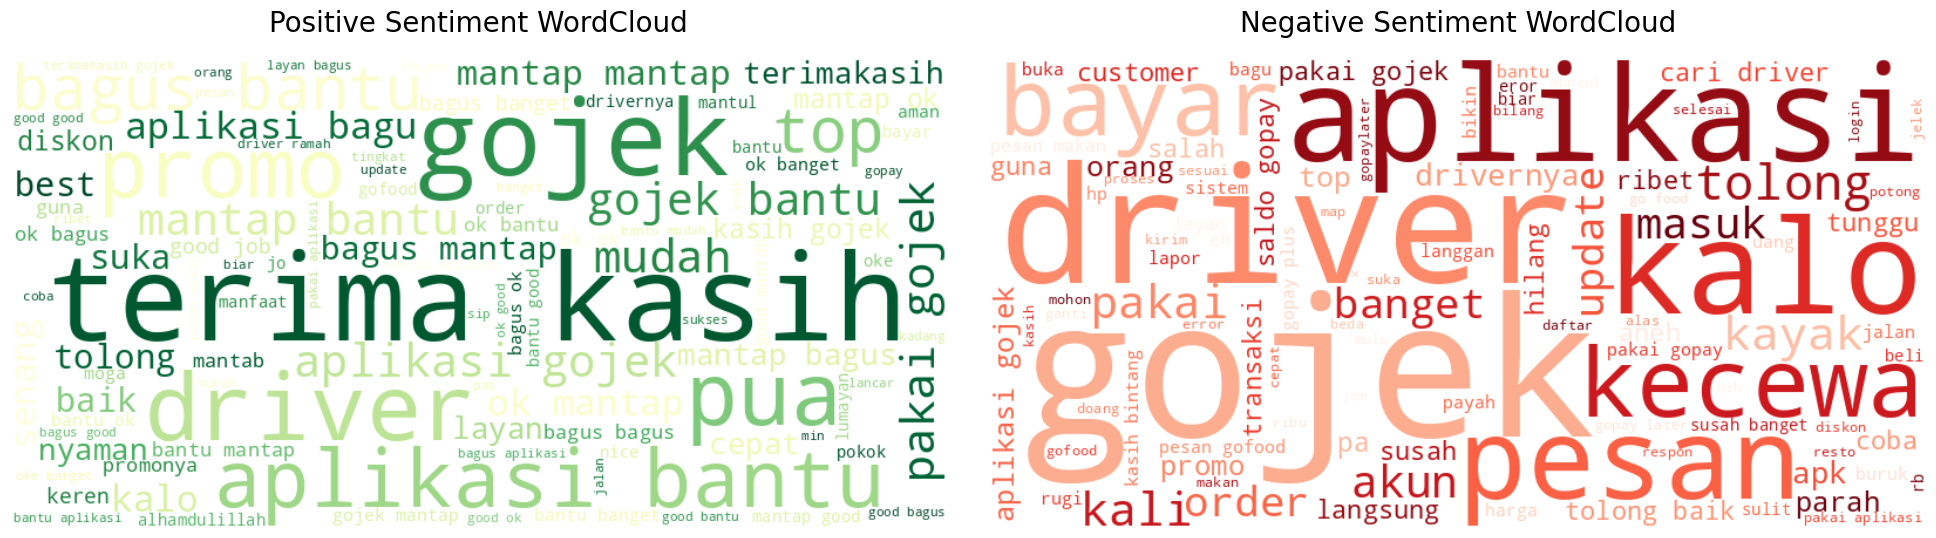


Top 10 words in Positive Reviews:
---------------------------------
bantu: 20238
mantap: 17367
gojek: 17304
bagus: 17198
ok: 13508
aplikasi: 11097
good: 10706
banget: 7198
mudah: 7193
kasih: 5660

Top 10 words in Negative Reviews:
---------------------------------
gojek: 14077
aplikasi: 12494
driver: 12239
pakai: 9976
gopay: 8559
pesan: 6838
banget: 6645
tolong: 4717
masuk: 4665
bayar: 4640


In [ ]:
# Memisahkan teks berdasarkan label
positive_text = ' '.join(df[df['label'] == 'positive']['text_processed'])
negative_text = ' '.join(df[df['label'] == 'negative']['text_processed'])

# Membuat figure dengan 2 subplot
plt.figure(figsize=(20,10))

# WordCloud untuk sentimen positif
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=100,
                             colormap='YlGn').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment WordCloud', fontsize=20, pad=20)
plt.axis('off')

# WordCloud untuk sentimen negatif
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=100,
                             colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment WordCloud', fontsize=20, pad=20)
plt.axis('off')

plt.tight_layout(pad=3.0)
plt.show()

# Tampilkan kata-kata yang paling sering muncul untuk setiap sentimen
from collections import Counter
import re

def get_top_words(text, n=10):
    # Pisahkan teks menjadi kata-kata
    words = text.split()
    # Hitung frekuensi kata
    word_freq = Counter(words)
    return word_freq.most_common(n)

print("\nTop 10 words in Positive Reviews:")
print("---------------------------------")
for word, freq in get_top_words(positive_text):
    print(f"{word}: {freq}")

print("\nTop 10 words in Negative Reviews:")
print("---------------------------------")
for word, freq in get_top_words(negative_text):
    print(f"{word}: {freq}")

# 5. Splitting Train & Test

In [19]:
# Membuat dataframe df_clean yang hanya berisi kolom text_processed dan label
df_clean = df[['text_processed', 'label']]

In [20]:
# Encode kolom 'label' menjadi angka
le = LabelEncoder()
df_clean['label'] = le.fit_transform(df_clean['label'])

In [21]:
# Membagi data menjadi feature (X) dan target (y)
X = df_clean[['text_processed']]
y = df_clean['label']

In [22]:
# Splitting data untuk train dan test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# 6. Modeling With Machine Learning

In [ ]:
# Membuat transformer untuk text
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

In [ ]:
# Membuat preprocessor untuk text
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'text_processed')
    ])

In [ ]:
# Mendefinisikan pipeline untuk berbagai model
# Membuat pipeline untuk model dan preprocessing
# Di dalam pipeline, kita akan menggunakan TF-IDF untuk teks
# Menggunakan randomUnderSampler untuk under-sampling karena data imbalance

# 1. TF-IDF untuk 'text_processed'
# 2. Under-sampling untuk mengatasi imbalance
# 3. Beberapa model machine learning: Logistic Regression, Naive Bayes, KNN, SVM, dan Random Forest

pipelines = {
    'logistic_regression': Pipeline([
        ('preprocessor', preprocessor),
        ('imb_pipeline', ImbPipeline([
            ('sampling', RandomUnderSampler(random_state=42)),
            ('classifier', LogisticRegression(random_state=42))
        ]))
    ]),

    'naive_bayes': Pipeline([
        ('preprocessor', preprocessor),
        ('imb_pipeline', ImbPipeline([
            ('sampling', RandomUnderSampler(random_state=42)),
            ('classifier', MultinomialNB())
        ]))
    ]),

    'knn': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', KNeighborsClassifier())
    ]),

    'svm': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', SVC(random_state=42))
    ]),

    'random_forest': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

# 7. Model Evaluation

## 7.1 Classification Report

In [ ]:
# Training dan evaluasi
predictions = {}
confidence_scores = {}
for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")

    # Fit model ke data training
    pipeline.fit(X_train, y_train)

    # Prediksi pada data uji
    y_pred = pipeline.predict(X_test)

    # Simpan hasil prediksi
    predictions[name] = y_pred

    # Evaluasi model
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))


Training logistic_regression...

Classification Report for logistic_regression:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     10675
           1       0.97      0.90      0.94     32434

    accuracy                           0.91     43109
   macro avg       0.87      0.92      0.89     43109
weighted avg       0.92      0.91      0.91     43109


Training naive_bayes...

Classification Report for naive_bayes:
              precision    recall  f1-score   support

           0       0.64      0.96      0.77     10675
           1       0.99      0.82      0.90     32434

    accuracy                           0.86     43109
   macro avg       0.81      0.89      0.83     43109
weighted avg       0.90      0.86      0.87     43109


Training knn...

Classification Report for knn:
              precision    recall  f1-score   support

           0       0.72      0.51      0.60     10675
           1       0.85      0.93      0.8

- Logistic regression dan SVM adalah pilihan terbaik, keduanya memiliki akurasi 91% dan F1-score yang baik di kedua kelas. Logistic regression sedikit lebih unggul dalam hasil dibandingkan dengan SVM
- Random forest adalah alternatif yang kuat dengan akurasi mendekati 90%

## 7.2 Confusion Matrix

Confusion Matrix for logistic_regression:
[[ 9887   788]
 [ 3108 29326]]
Confusion Matrix for naive_bayes:
[[10282   393]
 [ 5763 26671]]
Confusion Matrix for knn:
[[ 5454  5221]
 [ 2148 30286]]
Confusion Matrix for svm:
[[10028   647]
 [ 3262 29172]]
Confusion Matrix for random_forest:
[[ 9952   723]
 [ 3778 28656]]


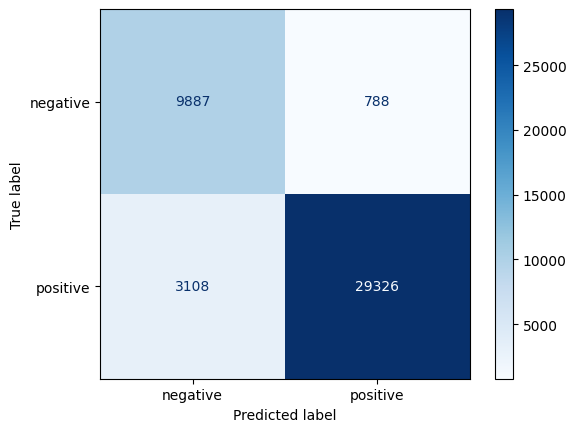

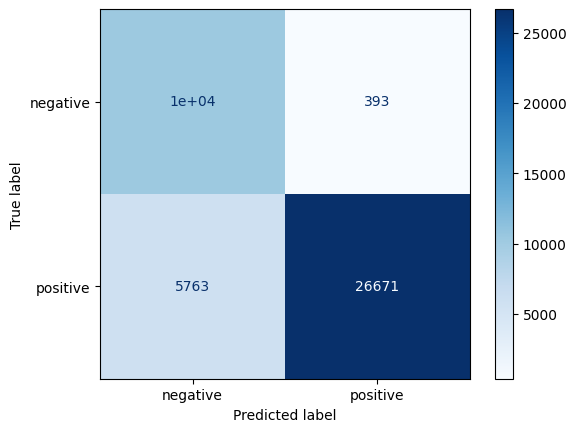

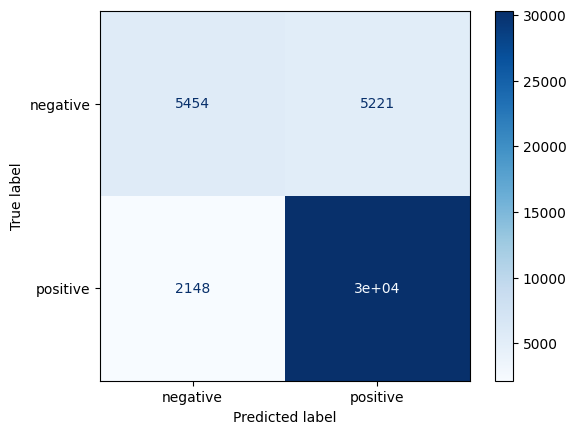

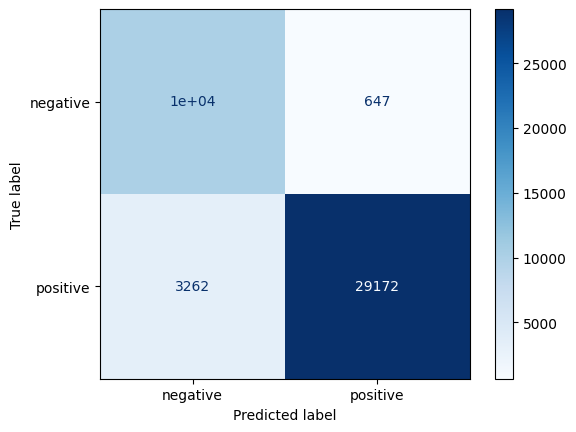

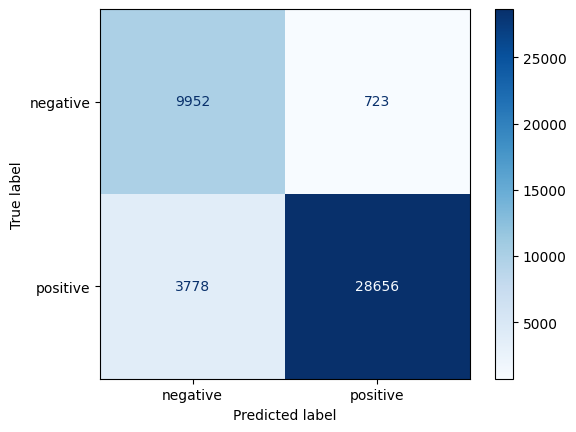

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Misalkan Anda memiliki pipelines yang sudah didefinisikan seperti 'logistic_regression' dan 'svm'
for model_name, pipeline in pipelines.items():
    # Fit model pada training set
    pipeline.fit(X_train, y_train)  # Pastikan untuk fit pipeline pada training data

    # Prediksi pada test set
    y_pred = pipeline.predict(X_test)  # Gunakan pipeline untuk melakukan prediksi

    # Hitung dan tampilkan confusion matrix
    cm = confusion_matrix(y_test, y_pred)  # Hitung confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)  # Menampilkan confusion matrix
    disp.plot(cmap='Blues')  # Plot confusion matrix dengan warna biru

    print(f"Confusion Matrix for {model_name}:")
    print(cm)

## 7.3 Cross-Validation

In [ ]:
# Menyimpan hasil cross-validation untuk setiap model
cv_results = {}

# Cross-validation untuk setiap pipeline
for name, pipeline in pipelines.items():
    print(f"\nCross-validating {name}...")

    # Evaluasi menggunakan cross-validation dengan f1_macro
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')

    # Menyimpan hasil cross-validation
    cv_results[name] = {
        'all_scores': cv_scores,
        'mean_f1': cv_scores.mean(),
        'std_f1': cv_scores.std(),
        'range_f1': (cv_scores.mean() - cv_scores.std(), cv_scores.mean() + cv_scores.std())
    }

    # Menampilkan hasil cross-validation
    print(f"{name.capitalize()} - All - Cross Validation  : ", cv_scores)
    print(f"{name.capitalize()} - Mean - Cross Validation : ", cv_results[name]['mean_f1'])
    print(f"{name.capitalize()} - Std - Cross Validation  : ", cv_results[name]['std_f1'])
    print(f"{name.capitalize()} - Range of f1_score       : ", cv_results[name]['range_f1'])


Cross-validating logistic_regression...
Logistic_regression - All - Cross Validation  :  [0.93676335 0.93595782 0.93745856 0.93707025 0.93447052]
Logistic_regression - Mean - Cross Validation :  0.9363440987596465
Logistic_regression - Std - Cross Validation  :  0.0010587348942188571
Logistic_regression - Range of f1_score       :  (0.9352853638654277, 0.9374028336538653)

Cross-validating naive_bayes...
Naive_bayes - All - Cross Validation  :  [0.89707622 0.8975389  0.89970489 0.89739145 0.89375875]
Naive_bayes - Mean - Cross Validation :  0.8970940435346343
Naive_bayes - Std - Cross Validation  :  0.0019093123413988365
Naive_bayes - Range of f1_score       :  (0.8951847311932355, 0.8990033558760331)

Cross-validating knn...
Knn - All - Cross Validation  :  [0.88712499 0.8898916  0.88687249 0.89016342 0.88649285]
Knn - Mean - Cross Validation :  0.8881090703154007
Knn - Std - Cross Validation  :  0.0015816113618550708
Knn - Range of f1_score       :  (0.8865274589535456, 0.8896906816

- Logistic regression memiliki performa terbaik dengan rata-rata f1-score tertinggi di antara semua model. Standar deviasi yang kecil menunjukkan konsistensi hasil yang baik.
- SVM memiliki performa yang hampir sama dengan logistic regression dalam hal rata-rata f1-score. Namun, SVM lebih konsisten karena memiliki standar deviasi yang paling kecil.

# 8. Model Inference

In [ ]:
# Contoh data baru untuk inferensi
data_baru = pd.DataFrame({
    'text_processed': ["Saya sangat puas dengan layanan Gojek, driver selalu cepat datang dan pelayanan sangat ramah. Aplikasi juga sangat mudah digunakan.",
                       "Gojek sangat membantu saya dalam keseharian, terutama di tengah kemacetan. Driver selalu tepat waktu dan terpercaya!",
                       "Gojek memberikan pengalaman yang luar biasa, saya merasa nyaman menggunakan layanan mereka. Pesanan makanan selalu cepat sampai!",
                       "Sangat senang dengan fitur Gopay yang memudahkan pembayaran, dan saya juga sering mendapat promo menarik dari Gojek!",
                       "Layanan antar barang menggunakan Gojek sangat efisien. Pengiriman cepat dan trackingnya juga sangat akurat.",
                       "mantap, selalu error gabisa diharapkan",
                       "Aplikasi Gojek sering mengalami gangguan, saya sering tidak bisa masuk atau aplikasi freeze saat memesan.",
                       "Harga yang dibebankan untuk layanan Gojek terkadang tidak sesuai dengan jarak yang ditempuh, merasa terlalu mahal untuk beberapa perjalanan.",
                       "Driver Gojek saya beberapa kali tidak ramah dan bahkan tidak sabar menunggu saat saya masih dalam perjalanan menuju titik jemput.",
                       "Seringkali saya mendapat pengemudi yang tidak mengerti rute, jadi perjalanan saya jadi lebih lama dari yang seharusnya.",
                       "Customer service Gojek susah dihubungi, dan masalah saya tidak kunjung selesai meskipun sudah menghubungi mereka beberapa kali.",
                       "keren nih gojek, selalu bikin orang marah pakenya",
                       ]
})

# Melakukan inference
X_baru = data_baru[['text_processed']]

# Melakukan prediksi untuk setiap model dalam pipeline
for model_name, pipeline in pipelines.items():
    print(f"Prediksi menggunakan model: {model_name}")

    # Melakukan inference pada data baru
    y_pred_baru = pipeline.predict(X_baru)

    # Menampilkan hasil prediksi
    print(f"Hasil prediksi untuk {model_name}: {y_pred_baru}")

    # Mengonversi hasil prediksi ke label asli
    y_pred_baru_label = le.inverse_transform(y_pred_baru)
    print(f"Hasil prediksi dengan label asli: {y_pred_baru_label}")
    print("\n")

Prediksi menggunakan model: logistic_regression
Hasil prediksi untuk logistic_regression: [1 1 1 1 1 1 0 0 1 1 0 0]
Hasil prediksi dengan label asli: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative' 'negative' 'positive' 'positive' 'negative' 'negative']


Prediksi menggunakan model: naive_bayes
Hasil prediksi untuk naive_bayes: [1 1 1 1 1 0 0 0 0 0 0 0]
Hasil prediksi dengan label asli: ['positive' 'positive' 'positive' 'positive' 'positive' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative']


Prediksi menggunakan model: knn
Hasil prediksi untuk knn: [1 1 0 1 1 1 0 1 1 1 1 1]
Hasil prediksi dengan label asli: ['positive' 'positive' 'negative' 'positive' 'positive' 'positive'
 'negative' 'positive' 'positive' 'positive' 'positive' 'positive']


Prediksi menggunakan model: svm
Hasil prediksi untuk svm: [1 1 1 1 1 1 0 0 1 0 0 0]
Hasil prediksi dengan label asli: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 '

- Logistic regression dan SVM adalah dua model yang memberikan hasil terbaik. Keduanya sangat stabil dan akurat dalam memprediksi kelas, dengan performa yang seimbang pada kedua kelas

- Secara keseluruhan, model naive bayes menunjukkan akurasi 86% dan F1-Score sekitar 0.83, yang sedikit lebih rendah dibandingkan dengan model logistic regression dan SVM. Namun, dalam contoh inference ini, model berhasil memberikan prediksi yang sangat tepat

- Random forest dan KNN masih mengalami kesulitan dalam memprediksi kelas

# 9. Model Building with Deep Learning

## 9.1 Splitting Train, Test, and Validation

In [ ]:
seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Splitting data menjadi train, test, dan validation
X_train_val, X_test_dl, y_train_val, y_test_dl = train_test_split(df_clean.text_processed,
                                                    df_clean.label,
                                                    test_size=0.15,
                                                    random_state=seed,
                                                    stratify=df_clean.label)

X_train_dl, X_val, y_train_dl, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=seed,
                                                  stratify=y_train_val)

print('Train Size : ', X_train_dl.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test_dl.shape)

Train Size :  (164889,)
Val Size   :  (18321,)
Test Size  :  (32332,)


In [ ]:
# Mengubah label menjadi one hot
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test_dl)

In [ ]:
# Menggunakan undersampling untuk mengatasi imbalance data
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=seed)
X_train_dl_resampled, y_train_dl_resampled = under_sampler.fit_resample(
    X_train_dl.values.reshape(-1, 1),
    y_train_dl
)

# Mengubah label menjadi one hot
y_train_dl_resampled = to_categorical(y_train_dl_resampled)

# Ubah jadi 1 dimensi (vector)
X_train_dl_resampled = X_train_dl_resampled.flatten()

y_train_dl_resampled


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## 9.2 Text Vectorization

In [ ]:
# Vektorisasi data training dan test menggunakan countvectorizer
Vectorizer = CountVectorizer()
X_train_vec = Vectorizer.fit_transform(X_train_dl_resampled.flatten())
X_test_vec = Vectorizer.transform(X_test_dl)

X_train_vec

<82882x34751 sparse matrix of type '<class 'numpy.int64'>'
	with 488825 stored elements in Compressed Sparse Row format>

In [ ]:
# Menemukan jumlah kosakata dan max token kength dalam dataset
total_vocab = len(Vectorizer.vocabulary_.keys())
# Menghitung panjang kalimat maksimum berdasarkan data training
max_sen_len = max([len(i.split(" ")) for i in X_train_dl_resampled.flatten()])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  30000
Maximum Sentence Length :  84 tokens


In [ ]:
# Menyiapkan text vectorization layer
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       output_mode="int",
                                       output_sequence_length=max_sen_len)

# Adaptasi text_vectorization ke data training
text_vectorization.adapt(X_train_dl_resampled.flatten())

In [ ]:
# Contoh
print('Contoh data')
print(df_clean.text_processed[0])
print('')

# Result of Text Vectorization
print('Hasil Text Vectorization')
print(text_vectorization([df_clean.text_processed[0]]))
print('Vector size : ', text_vectorization([df_clean.text_processed[0]]).shape)

Contoh data
akun gopay blok

Hasil Text Vectorization
tf.Tensor(
[[ 21   7 333   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 84), dtype=int64)
Vector size :  (1, 84)


In [ ]:
# Melihat top 20 token berdasarkan frekuensi kemunculan
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'gojek',
 'aplikasi',
 'nya',
 'driver',
 'pakai',
 'gopay',
 'banget',
 'bantu',
 'pesan',
 'bagus',
 'ya',
 'mantap',
 'tolong',
 'kasih',
 'bayar',
 'masuk',
 'kalo',
 'ok']

## 9.3 Word Embedding

In [ ]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [ ]:
# Document example
print('Contoh data')
print(df_clean.text_processed[0])
print('')

# Untuk melihat hasil text vectorization
print('Hasil text vectorization')
print(text_vectorization([df_clean.text_processed[0]]))
print('Vector size : ', text_vectorization([df_clean.text_processed[0]]).shape)
print('')

# Melihat hasil embedding
print('Hasil embedding')
print(embedding(text_vectorization([df_clean.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df_clean.text_processed[0]])).shape)

Contoh data
akun gopay blok

Hasil text vectorization
tf.Tensor(
[[ 21   7 333   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 84), dtype=int64)
Vector size :  (1, 84)

Hasil embedding
tf.Tensor(
[[[ 0.029237   -0.23387726  0.3826065  ... -0.01630671 -0.42749813
    0.31346023]
  [-0.27544302 -0.14530165 -0.07237709 ... -0.07105168 -0.20552918
   -0.01679335]
  [ 0.2838854   0.2933235   0.23583241 ...  0.16378236 -0.00050384
    0.24836586]
  ...
  [ 0.0522192  -0.2870211  -0.06016025 ... -0.01370031 -0.4300039
   -0.16584678]
  [ 0.0522192  -0.2870211  -0.06016025 ... -0.01370031 -0.4300039
   -0.16584678]
  [ 0.0522192  -0.2870211  -0.06016025 ... -0.01370031 -0.4300039
   -0.16584678]]], sha

## 9.4 Modeling with LSTM

In [ ]:
tf.keras.backend.clear_session()

# Modeling menggunakan LSTM
model_lstm_1 = Sequential([
    text_vectorization,
    embedding,
    Bidirectional(LSTM(32, return_sequences=True,
                       kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))),
    Dropout(0.1),
    Bidirectional(LSTM(16,
                       kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))),
    Dropout(0.1),
    Dense(2, activation='softmax')
])

# Compile
model_lstm_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
model_lstm_1_hist = model_lstm_1.fit(
    X_train_dl_resampled.flatten(),
    y_train_dl_resampled,
    epochs=10,
    validation_data=(X_val, y_val_ohe),
    batch_size=16,
    verbose=1
)

Epoch 1/10
5181/5181 [==============================] - 709s 135ms/step - loss: 0.1535 - accuracy: 0.9499 - val_loss: 0.3175 - val_accuracy: 0.8932
Epoch 2/10
5181/5181 [==============================] - 554s 107ms/step - loss: 0.1338 - accuracy: 0.9561 - val_loss: 0.3342 - val_accuracy: 0.8870
Epoch 3/10
5181/5181 [==============================] - 554s 107ms/step - loss: 0.1234 - accuracy: 0.9598 - val_loss: 0.3483 - val_accuracy: 0.8852
Epoch 4/10
5181/5181 [==============================] - 550s 106ms/step - loss: 0.1153 - accuracy: 0.9617 - val_loss: 0.4012 - val_accuracy: 0.8869
Epoch 5/10
5181/5181 [==============================] - 2147s 415ms/step - loss: 0.1089 - accuracy: 0.9643 - val_loss: 0.4236 - val_accuracy: 0.8859
Epoch 6/10
5181/5181 [==============================] - 571s 110ms/step - loss: 0.1034 - accuracy: 0.9659 - val_loss: 0.4235 - val_accuracy: 0.8852
Epoch 7/10
5181/5181 [==============================] - 600s 116ms/step - loss: 0.0984 - accuracy: 0.9677 - val

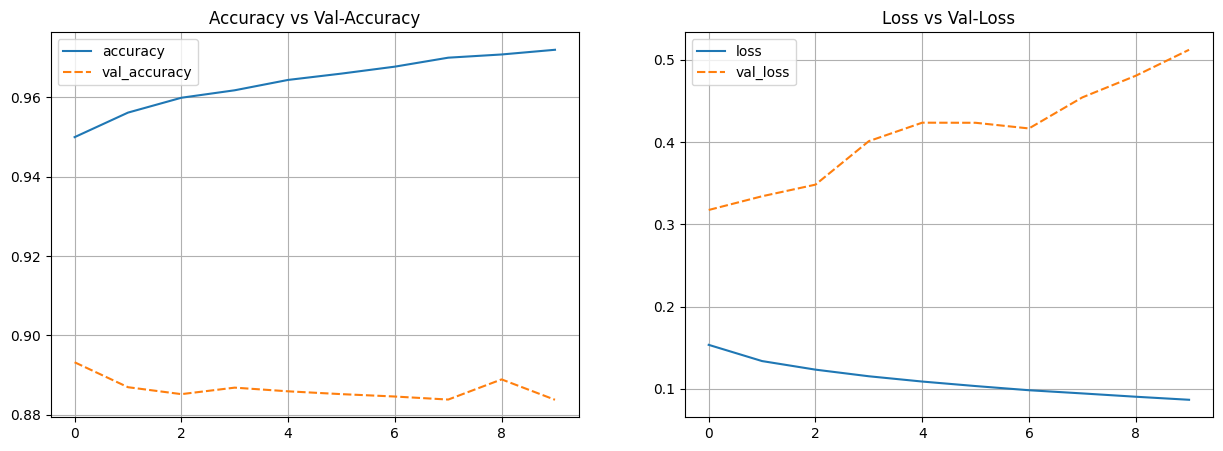

In [ ]:
# Plot hasil training

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

- Walaupun sudah menggunakan dropout, model masih mengalami overfitting, dapat dilihat dari perbedaan antara akurasi training yang tinggi dan penurunan akurasi pada data validation.
- Model menunjukkan peningkatan akurasi yang stabil pada data training. Loss pada data training menurun secara konsisten, yang menunjukkan peningkatan dalam klasifikasi data training
- Akurasi validation mengalami kenaikan dan penurunan yang tidak signifikan. Loss pada data validation mengalami peningkatan yang cukup besar

## 9.5 Evaluation

In [ ]:
# Ubah ke numpy array dan flatten
if isinstance(X_test_dl, np.ndarray):
    X_test_dl = X_test_dl.flatten()
elif isinstance(X_test_dl, pd.Series):
    X_test_dl = X_test_dl.values.flatten()

# Lakukan prediksi
y_pred_dl = model_lstm_1.predict(X_test_dl)
y_pred_classes_dl = np.argmax(y_pred_dl, axis=1)
y_test_classes_dl = np.argmax(y_test_ohe, axis=1)

# Hasilkan classification report
report_dl = classification_report(y_test_classes_dl, y_pred_classes_dl,
                               target_names=['Negatif', 'Positif'],
                               digits=4)
print(report_dl)

1011/1011 [==============================] - 34s 34ms/step
              precision    recall  f1-score   support

     Negatif     0.7040    0.9189    0.7972      8126
     Positif     0.9697    0.8703    0.9173     24206

    accuracy                         0.8825     32332
   macro avg     0.8368    0.8946    0.8572     32332
weighted avg     0.9029    0.8825    0.8871     32332



Model LSTM menunjukkan akurasi keseluruhan sebesar 88.25%. Model memiliki performa yang sangat baik dalam mengklasifikasikan kelas positive. Namun, untuk kelas negative terdapat lebih banyak kesalahan saat diprediksi. Secara keseluruhan, model cenderung lebih baik dalam mengidentifikasi kelas mayoritas positive.

## 9.6 Inference

In [ ]:
# Contoh data baru untuk inferensi
data_baru = pd.DataFrame({
    'text_processed': ["Saya sangat puas dengan layanan Gojek, driver selalu cepat datang dan pelayanan sangat ramah. Aplikasi juga sangat mudah digunakan.",
                       "Gojek sangat membantu saya dalam keseharian, terutama di tengah kemacetan. Driver selalu tepat waktu dan terpercaya!",
                       "Gojek memberikan pengalaman yang luar biasa, saya merasa nyaman menggunakan layanan mereka. Pesanan makanan selalu cepat sampai!",
                       "Sangat senang dengan fitur Gopay yang memudahkan pembayaran, dan saya juga sering mendapat promo menarik dari Gojek!",
                       "Layanan antar barang menggunakan Gojek sangat efisien. Pengiriman cepat dan trackingnya juga sangat akurat.",
                       "mantap, selalu error gabisa diharapkan",
                       "Aplikasi Gojek sering mengalami gangguan, saya sering tidak bisa masuk atau aplikasi freeze saat memesan.",
                       "Harga yang dibebankan untuk layanan Gojek terkadang tidak sesuai dengan jarak yang ditempuh, merasa terlalu mahal untuk beberapa perjalanan.",
                       "Driver Gojek saya beberapa kali tidak ramah dan bahkan tidak sabar menunggu saat saya masih dalam perjalanan menuju titik jemput.",
                       "Seringkali saya mendapat pengemudi yang tidak mengerti rute, jadi perjalanan saya jadi lebih lama dari yang seharusnya.",
                       "Customer service Gojek susah dihubungi, dan masalah saya tidak kunjung selesai meskipun sudah menghubungi mereka beberapa kali.",
                       "keren nih gojek, selalu bikin orang marah pakenya",
                       ]
})


# Convert ke numpy array
inference_data = np.array(data_baru['text_processed'].values)

# Predict
predictions = model_lstm_1.predict(inference_data)
predicted_classes = np.argmax(predictions, axis=1)

# Convert ke label positive / negative
labels = ['negative', 'positive']
predicted_labels = np.array([labels[i] for i in predicted_classes])

print("Prediksi menggunakan model LSTM")
print(f"Hasil prediksi untuk LSTM: \n{predicted_classes}")
print(f"Hasil prediksi dengan label asli: {predicted_labels}")

1/1 [==============================] - 0s 205ms/step
Prediksi menggunakan model LSTM
Hasil prediksi untuk LSTM: 
[1 0 0 0 0 0 0 0 0 0 0 1]
Hasil prediksi dengan label asli: ['positive' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'positive']


Berdasarkan hasil prediksi yang sangat rendah, dapat disimpulkan bahwa model LSTM tidak efektif dalam mengklasifikasikan sentimen pada data ini. Hanya 2 dari 12 prediksi yang benar menunjukkan bahwa model belum terlatih dengan baik.

# 10. LSTM with Transfer Learning

Berikutnya improve model menggunakan transfer learning dari embedding layer Google news 3B corpus

[Embedding layer source](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fmodels%2Fgoogle%2Fnnlm%2FtensorFlow2%2Ftf2-preview-id-dim128-with-normalization%2F1) <br>
[List of Embedding Layers](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fmodels%3Fquery%3Dtext%2Bembedding)

In [ ]:
# Download layer embedding
url = 'https://www.kaggle.com/models/google/nnlm/tensorFlow2/tf2-preview-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Download versi terakhir dan load
tfl = kagglehub.model_download("google/nnlm/tensorFlow2/tf2-preview-id-dim128-with-normalization")

print("Path to model files:", tfl)

hub_layer = tf_hub.KerasLayer(r'C:\Users\User\.cache\kagglehub\models\google\nnlm\tensorFlow2\tf2-preview-id-dim128-with-normalization\1', output_shape=[128], input_shape=[], dtype=tf.string)

Path to model files: C:\Users\User\.cache\kagglehub\models\google\nnlm\tensorFlow2\tf2-preview-id-dim128-with-normalization\1


In [ ]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Membangun layer
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(2, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train_dl_resampled, y_train_dl_resampled, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10
2591/2591 [==============================] - 203s 74ms/step - loss: 0.5269 - accuracy: 0.7446 - val_loss: 0.4602 - val_accuracy: 0.7912
Epoch 2/10
2591/2591 [==============================] - 199s 77ms/step - loss: 0.4596 - accuracy: 0.7904 - val_loss: 0.4145 - val_accuracy: 0.8240
Epoch 3/10
2591/2591 [==============================] - 187s 72ms/step - loss: 0.4211 - accuracy: 0.8153 - val_loss: 0.3822 - val_accuracy: 0.8356
Epoch 4/10
2591/2591 [==============================] - 185s 71ms/step - loss: 0.3977 - accuracy: 0.8278 - val_loss: 0.3846 - val_accuracy: 0.8354
Epoch 5/10
2591/2591 [==============================] - 186s 72ms/step - loss: 0.3820 - accuracy: 0.8360 - val_loss: 0.4019 - val_accuracy: 0.8209
Epoch 6/10
2591/2591 [==============================] - 186s 72ms/step - loss: 0.3746 - accuracy: 0.8404 - val_loss: 0.3681 - val_accuracy: 0.8412
Epoch 7/10
2591/2591 [==============================] - 188s 72ms/step - loss: 0.3683 - accuracy: 0.8436 - val_loss: 0

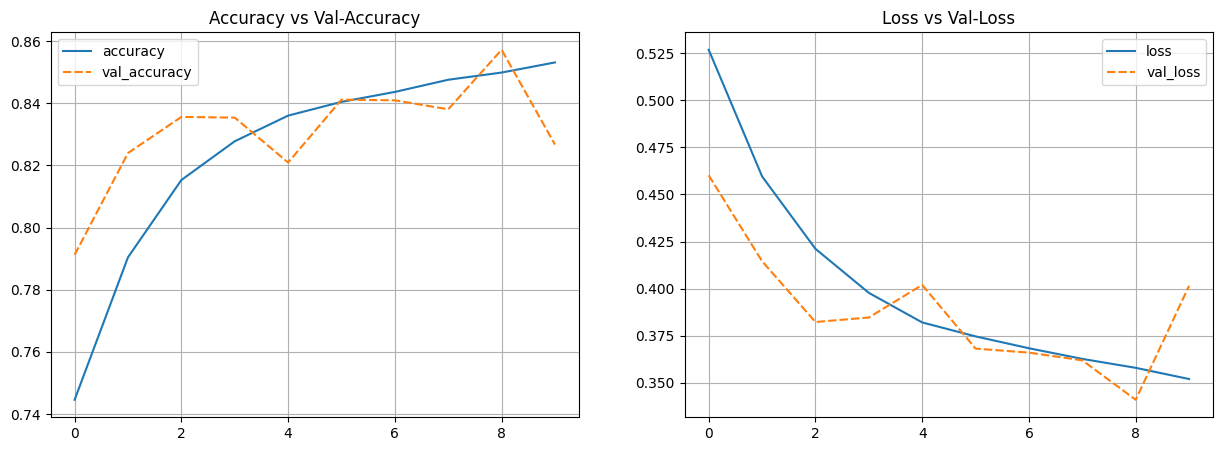

In [ ]:
# Plot hasil training
model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

- Model menunjukkan tanda-tanda overfitting pada data training. Hal ini dapat dilihat dari penurunan performa pada data validation tetapi performa training terus mengalami meningkat

- Akurasi pada data training meningkat secara konsisten dari. Loss pada data training terus menurun, menunjukkan bahwa model semakin baik dalam meminimalkan kesalahan pada data training

- Akurasi validation juga mengalami peningkatan. Loss validation mengalami fluktuasi, namun secara umum menunjukkan tren penurunan tetapi mengalami kenaikan lagi pada epoch terakhir, sebesar 0.4015

## 10.1 Evaluation

In [ ]:
# Classification report
y_pred_tl = model_lstm_2.predict(X_test_dl)
y_pred_classes_tl = np.argmax(y_pred_tl, axis=1)
y_test_classes_tl = np.argmax(y_test_ohe, axis=1)

# 3. Hasilkan classification report
report_dl = classification_report(y_test_classes_tl, y_pred_classes_tl,
                               target_names=['Negatif', 'Positif'],
                               digits=4)
print(report_dl)

1011/1011 [==============================] - 41s 40ms/step
              precision    recall  f1-score   support

     Negatif     0.5980    0.9126    0.7226      8126
     Positif     0.9644    0.7941    0.8710     24206

    accuracy                         0.8239     32332
   macro avg     0.7812    0.8533    0.7968     32332
weighted avg     0.8723    0.8239    0.8337     32332



Model transfer mencapai akurasi 82.39% dengan kinerja yang lebih baik untuk kelas positive dibandingkan dengan kelas negative. Secara keseluruhan, model menunjukkan kinerja yang kurang lebih sama dengan model LSTM.

## 10.2 Inference

In [ ]:
# Contoh data baru untuk inferensi
data_baru = pd.DataFrame({
    'text_processed': ["Saya sangat puas dengan layanan Gojek, driver selalu cepat datang dan pelayanan sangat ramah. Aplikasi juga sangat mudah digunakan.",
                       "Gojek sangat membantu saya dalam keseharian, terutama di tengah kemacetan. Driver selalu tepat waktu dan terpercaya!",
                       "Gojek memberikan pengalaman yang luar biasa, saya merasa nyaman menggunakan layanan mereka. Pesanan makanan selalu cepat sampai!",
                       "Sangat senang dengan fitur Gopay yang memudahkan pembayaran, dan saya juga sering mendapat promo menarik dari Gojek!",
                       "Layanan antar barang menggunakan Gojek sangat efisien. Pengiriman cepat dan trackingnya juga sangat akurat.",
                       "mantap, selalu error gabisa diharapkan",
                       "Aplikasi Gojek sering mengalami gangguan, saya sering tidak bisa masuk atau aplikasi freeze saat memesan.",
                       "Harga yang dibebankan untuk layanan Gojek terkadang tidak sesuai dengan jarak yang ditempuh, merasa terlalu mahal untuk beberapa perjalanan.",
                       "Driver Gojek saya beberapa kali tidak ramah dan bahkan tidak sabar menunggu saat saya masih dalam perjalanan menuju titik jemput.",
                       "Seringkali saya mendapat pengemudi yang tidak mengerti rute, jadi perjalanan saya jadi lebih lama dari yang seharusnya.",
                       "Customer service Gojek susah dihubungi, dan masalah saya tidak kunjung selesai meskipun sudah menghubungi mereka beberapa kali.",
                       "keren nih gojek, selalu bikin orang marah pakenya",
                       ]
})

# Convert ke numpy array
inference_data = np.array(data_baru['text_processed'].values)

# Predict
predictions = model_lstm_2.predict(inference_data)
predicted_classes = np.argmax(predictions, axis=1)

# Convert ke label positive / negative
labels = ['negative', 'positive']  # Make sure this matches your training labels order
predicted_labels = np.array([labels[i] for i in predicted_classes])

print("Prediksi menggunakan model transfer learning")
print(f"Hasil prediksi untuk transfer learning: \n{predicted_classes}")
print(f"Hasil prediksi dengan label asli: {predicted_labels}")

1/1 [==============================] - 0s 135ms/step
Prediksi menggunakan model transfer learning
Hasil prediksi untuk transfer learning: 
[0 0 0 0 0 1 0 0 0 0 0 0]
Hasil prediksi dengan label asli: ['negative' 'negative' 'negative' 'negative' 'negative' 'positive'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative']


Model transfer learning menunjukkan hasil yang kurang optimal, terutama dalam hal prediksi sentimen positive. Sebagian besar ulasan yang seharusnya positive justru diprediksi sebagai negative. Ini menunjukkan bahwa model mungkin terlatih lebih baik pada data yang memiliki sentimen negative, atau kesulitan menangkap konteks dari ulasan yang positive.

# 11. Hyperparameter Tuning

In [23]:
# Membuat transformer untuk text
text_transformer_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000))
])

# Membuat preprocessor untuk text
preprocessor_svm = ColumnTransformer(
    transformers=[
        ('text', text_transformer_svm, 'text_processed')
    ])

pipeline_svm = ImbPipeline([
    ('preprocessor', preprocessor_svm),
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', SVC(random_state=42, probability=True))
])

pipeline_svm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=3000))]),
                                                  'text_processed')])),
                ('sampling', RandomUnderSampler(random_state=42)),
                ('classifier', SVC(probability=True, random_state=42))])

In [24]:
param_dist = {'classifier__C': [0.1, 1, 10, 100],  
              'classifier__gamma': [1, 0.1, 0.01], 
              'classifier__kernel': ['linear', 'rbf', 'poly'],
              #'classifier__gamma': ['scale', 'auto'] + list(uniform(0.001, 1).rvs(10)),
              #'classifier__coef0': uniform(0.0, 1.0)
}

In [25]:
# Membuat RandomizedSearchCV untuk SVM dengan pipeline
svm_random_search = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=3,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [26]:
# Melatih model dengan RandomizedSearchCV
svm_random_search.fit(X_train, y_train)

# Menampilkan parameter terbaik yang ditemukan
print("Best parameters found: ", svm_random_search.best_params_)

# Mengakses model terbaik setelah pencarian
best_model = svm_random_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found:  {'classifier__kernel': 'rbf', 'classifier__gamma': 0.1, 'classifier__C': 1}


## 11.1 Model Evaluation

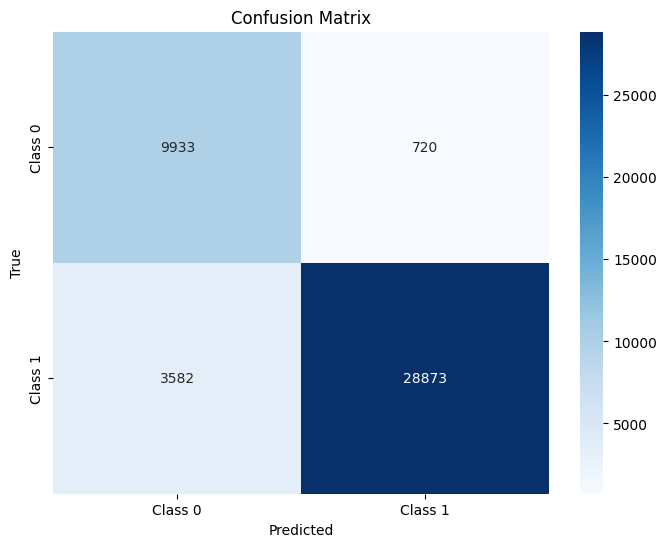

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82     10653
           1       0.98      0.89      0.93     32455

    accuracy                           0.90     43108
   macro avg       0.86      0.91      0.88     43108
weighted avg       0.92      0.90      0.90     43108



In [29]:
# Prediksi menggunakan model terbaik yang ditemukan
y_pred_tuning = best_model.predict(X_test)

# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred_tuning)

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_tuning))

Classification Report for svm:<br>
              precision    recall  f1-score   support

           0       0.75      0.94      0.84     10675
           1       0.98      0.90      0.94     32434

    accuracy                           0.91     43109
   macro avg       0.87      0.92      0.89     43109
weighted avg       0.92      0.91      0.91     43109

In [30]:
# Contoh data baru untuk inferensi
data_baru = pd.DataFrame({
    'text_processed': ["Saya sangat puas dengan layanan Gojek, driver selalu cepat datang dan pelayanan sangat ramah. Aplikasi juga sangat mudah digunakan.", 
                       "Gojek sangat membantu saya dalam keseharian, terutama di tengah kemacetan. Driver selalu tepat waktu dan terpercaya!", 
                       "Gojek memberikan pengalaman yang luar biasa, saya merasa nyaman menggunakan layanan mereka. Pesanan makanan selalu cepat sampai!", 
                       "Sangat senang dengan fitur Gopay yang memudahkan pembayaran, dan saya juga sering mendapat promo menarik dari Gojek!",
                       "Layanan antar barang menggunakan Gojek sangat efisien. Pengiriman cepat dan trackingnya juga sangat akurat.",
                       "mantap, selalu error gabisa diharapkan",
                       "Aplikasi Gojek sering mengalami gangguan, saya sering tidak bisa masuk atau aplikasi freeze saat memesan.",
                       "Harga yang dibebankan untuk layanan Gojek terkadang tidak sesuai dengan jarak yang ditempuh, merasa terlalu mahal untuk beberapa perjalanan.",
                       "Driver Gojek saya beberapa kali tidak ramah dan bahkan tidak sabar menunggu saat saya masih dalam perjalanan menuju titik jemput.",
                       "Seringkali saya mendapat pengemudi yang tidak mengerti rute, jadi perjalanan saya jadi lebih lama dari yang seharusnya.",
                       "Customer service Gojek susah dihubungi, dan masalah saya tidak kunjung selesai meskipun sudah menghubungi mereka beberapa kali.",
                       "keren nih gojek, selalu bikin orang marah pakenya",
                       ]
})


# Gunakan pipeline yang sudah terlatih untuk memproses data baru
predictions_best_model = best_model.predict(data_baru)

# Convert prediksi ke label (jika perlu)
labels = ['negative', 'positive']
predicted_labels = np.array([labels[i] for i in predictions_best_model])

print("Prediksi menggunakan model terbaik (SVM):")
print(f"Hasil prediksi dengan label: {predicted_labels}")

Prediksi menggunakan model terbaik (SVM):
Hasil prediksi dengan label: ['positive' 'positive' 'positive' 'positive' 'positive' 'negative'
 'negative' 'negative' 'positive' 'negative' 'negative' 'negative']


In [31]:
# Buat dataframe baru dengan decision function dan prediksi
df_results = df_clean.copy()

# Melakukan prediksi menggunakan model terbaik (SVM)
predictions_best_model = best_model.predict(df_results)

# Menghitung confidence score menggunakan predict_proba (untuk seluruh data)
confidence_scores = best_model.predict_proba(df_results)[:, 1]

# Definisikan labels sesuai urutan LabelEncoder
labels = ['negative', 'positive']

# Convert prediksi ke label sesuai urutan LabelEncoder
predicted_labels = np.array([labels[i] for i in predictions_best_model])

# Retrieve the original label mapping 
original_labels = [labels[label] for label in df_results['label']]

# Menambahkan kolom hasil prediksi, original label, dan confidence score ke DataFrame df_results
df_results['original_label'] = original_labels
df_results['predictions'] = predicted_labels
df_results['confidence_score'] = [round(score, 2) for score in confidence_scores]

# Menampilkan hasil dengan urutan kolom yang diminta
df_results

,text_processed,label,original_label,predictions,confidence_score
0,akun gopay blok,0,negative,negative,0.03
2,kemarin buka aplikasi gojek kasih bintang kalo...,1,positive,negative,0.12
3,download gojek hape top gopay transaksi dialfa...,0,negative,negative,0.35
4,mantap,1,positive,positive,1.00
5,bagus,1,positive,positive,0.92
...,...,...,...,...,...
224997,gofood biaya ngotak mending hujan an beli makan,0,negative,negative,0.01
224998,yuk,1,positive,positive,0.75
224999,sempurna,1,positive,positive,0.92
225000,gojek pesan mapsnya hilang layar putih nama ke...,0,negative,negative,0.07


In [33]:
# Menampilkan wrong predictions
wrong_predictions = df_results[df_results['original_label'] != df_results['predictions']]

# Menampilkan hasil dengan urutan kolom yang diminta
print("\nWrong Predictions:")
print(wrong_predictions[['text_processed', 'label', 'original_label', 'predictions', 'confidence_score']])

# Menghitung jumlah wrong predictions
print(f"\nJumlah wrong predictions: {len(wrong_predictions)}")
print(f"Persentase wrong predictions: {(len(wrong_predictions)/len(df_results)*100):.2f}%")


Wrong Predictions:
                                           text_processed  label  \
2       kemarin buka aplikasi gojek kasih bintang kalo...      1   
9                biar aman pakai gojek uninstal biar aman      0   
19                                                             0   
26                     bagus banget sumpah wajib download      1   
32                                  lokasi cepat diupdate      1   
...                                                   ...    ...   
224972          mudah gunakantapi sulit tentu lokasi meep      1   
224982                                              no wa      1   
224985                                       ganti bang b      1   
224988                   gojek antar sabar cari alamat dl      1   
224989                         kesini mahal voucher pelit      1   

       original_label predictions  confidence_score  
2            positive    negative              0.12  
9            negative    positive              0.73  
1